## 📌 Project Title: YouTube Channel Performance Analysis – BellaFiori
### 🎯 Project Goal

The goal of this project is to analyze performance patterns across all videos published on the BellaFiori YouTube channel using the YouTube Data API.

This project aims to:

- Identify top-performing videos

- Analyze what types of content drive views and engagement

- Understand how publishing day affects performance

- Discover storytelling, emotional, or topic patterns that influence audience behavior

- Develop data-backed recommendations for improving the channel’s reach and interaction

In [58]:
import os
import pandas as pd
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import numpy as np

In [59]:
channel_id = 'UCaezsZGhwWgB4ZRmHNCfIyw'
api_key = os.environ.get('API')

In [60]:
## Get the upload playlist IDs
def get_uploads_playlist_id(channel_ID, api_key):
    """
    Fetches the Uploads Playlist ID from the Channel ID.
    """
    youtube = build('youtube', 'v3', developerKey= api_key)

    #Use 'ContentDetails' part to get the related playlists
    request = youtube.channels().list(part='contentDetails', id= channel_ID)
    response =request.execute()

    playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    return playlist_id
    

In [61]:
def get_all_playlist_video(playlist_id, api_key):
    """
    Fetches All video IDs from the given Uploads Playlist ID using playlistitems.list
    """
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_ids=[]
    next_page_token =None

    while True:
        request = youtube.playlistItems().list(
            part= 'contentDetails',
            playlistId = playlist_id,
            maxResults =50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

        if not next_page_token:
            break

    return video_ids

In [62]:
if api_key is not None:
    uploads_playlist_id = get_uploads_playlist_id(channel_id, api_key)
    print(f"Finding Uploads Playlist ID: {uploads_playlist_id}")

    all_video_ids = get_all_playlist_video(uploads_playlist_id, api_key)
    print(f"✅ Found a total of **{len(all_video_ids)}** videos.")
    print("\nNext Step: Get Statistics for these videos.")

Finding Uploads Playlist ID: UUaezsZGhwWgB4ZRmHNCfIyw
✅ Found a total of **498** videos.

Next Step: Get Statistics for these videos.


In [63]:
def get_channel_stats(channel_ID, api_key):
    """
    Fetches high-level statistics ( Subscribers, Views, Video Count).
    """
    youtube = build('youtube', 'v3', developerKey=api_key)

    
    request = youtube.channels().list(
    part = 'snippet, statistics',
    id = channel_ID
    )
    response = request.execute()

    if response['items']:
        stats = response['items'][0]['statistics']
        snippet = response['items'][0]['snippet']

        return { 
            'Channel Name' : snippet['title'],
            'Subscribers': int(stats.get('subscriberCount',0)),
            'Total Videos': int(stats.get('videoCount',0)),
            'Total Views': int(stats.get('viewCount',0))
        }
    return None

overall_stats = get_channel_stats(channel_id, api_key)

if overall_stats:
    print(f"Channel Name: {overall_stats['Channel Name']}")
    print(f"Subscribers: {overall_stats['Subscribers']:,}")
    print(f"Total Videos: {overall_stats['Total Videos']:,}")
    print(f"Total Views: {overall_stats['Total Views']:,}")
    print("-------------------------------------------------------")
    

Channel Name: Bella Fiori
Subscribers: 2,600,000
Total Videos: 497
Total Views: 315,274,808
-------------------------------------------------------


In [64]:
def get_video_stats(video_ids, api_key):
    """
    Fetches statistics for videos, chunking IDs into groups of 50.
    """
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_data = []

    #Create chunks of 50 video IDs
    for i in range(0, len(video_ids), 50):
        chunk = video_ids[i:i + 50]
        video_ids_string = ','.join(chunk)

        #Use the 'video.list' endpoint to get detailed statistics 
        request =youtube.videos().list(
            part= 'snippet, statistics', 
            id = video_ids_string
        )
        response =request.execute()

        for item in response['items']:
            data = {
                'Video_Id' : item['id'],
                'Title' : item['snippet']['title'],
                'Published_date': item['snippet']['publishedAt'],
                'Views' : int(item['statistics'].get('viewCount', 0)),
                'Likes': int(item['statistics'].get('likeCount', 0)),
                'Comments': int(item['statistics'].get('commentCount',0))
            }
            video_data.append(data)

        return pd.DataFrame(video_data)


df_videos = get_video_stats(all_video_ids, api_key)
print(df_videos.head(10))

      Video_Id                                         Title  \
0  u-IJkvM46fU   The Heartbreaking Case of Adrianne Reynolds   
1  EV_FpDqbuDA  The Twisted Case of Jamie and Jennifer Faith   
2  vh1jUoHtcbc   GRWM for my WEDDING!!!!! My Wedding Makeup!   
3  rgGmDzPMA2w            The Disturbing Case of Bill Nelson   
4  DQyyy9LUvuU              SOLVED: The Case of Koh Yu-Jeong   
5  ILBFuvdhuRs        The Horrific Case of Lisa and Joel Guy   
6  YxpT9q_5s30           The Chilling Case of Michelle Young   
7  MQ2_nrz0Z0I     The Twisted Case of Dr. John Schneeberger   
8  V0bIpqD1vMA                          THE MUSHROOM MURDERS   
9  2xapky5Nq98                      The Case of Misty Copsey   

         Published_date   Views  Likes  Comments  
0  2025-11-30T19:01:02Z  255770   7436       365  
1  2025-11-24T19:00:11Z  341160   9231       702  
2  2025-11-04T19:00:59Z   80634   5764       409  
3  2025-10-31T20:01:00Z  250148   7743       293  
4  2025-10-21T19:00:21Z  337450   9768  

## 📊 Dataset Overview

We collected data from the YouTube Data API including:

- Video titles

- Publish dates

- View counts

- Likes

- Comments

- Engagement metrics

### Data Cleaning & Feature Engineering


In [65]:
#1. Convert Published_Date to proper datetime object

df_videos['Published_date'] = pd.to_datetime(df_videos['Published_date'])

#2.. Extract the day of the week, 
df_videos['Publish_Day'] = df_videos['Published_date'].dt.day_name()

#3. Feature Engineering : Calculate Engagement Rate
#This is a Critical KPI for YouTube analysis.
# We add a small number(1) to denominator to prevent division by zero for 0-views videos
df_videos['Engagement_Rate'] = (df_videos['Likes'] +df_videos['Comments'])/ (df_videos['Views'] +1)

#4. Feature Engineering: Calculate Engagement Per 1000 Views
# This normalizes engagement, making it easier to read. 
df_videos['Engagement_Per_1000_Views'] = df_videos['Engagement_Rate'] * 1000

print("\n--- Cleaned Data Head---")
print(df_videos[['Title', 'Views', 'Engagement_Per_1000_Views', 'Publish_Day']].head())


--- Cleaned Data Head---
                                          Title   Views  \
0   The Heartbreaking Case of Adrianne Reynolds  255770   
1  The Twisted Case of Jamie and Jennifer Faith  341160   
2   GRWM for my WEDDING!!!!! My Wedding Makeup!   80634   
3            The Disturbing Case of Bill Nelson  250148   
4              SOLVED: The Case of Koh Yu-Jeong  337450   

   Engagement_Per_1000_Views Publish_Day  
0                  30.499939      Sunday  
1                  29.115286      Monday  
2                  76.554846     Tuesday  
3                  32.124854      Friday  
4                  29.731724     Tuesday  


- Converted published dates into a proper datetime format

- Extracted the Publish_Day

- Created new metrics to better measure engagement

- Engagement per 1000 views



## Analysis

In [66]:
# 1. Top video by views

print("\n---Top 5 Videos by Views---")
print(df_videos.sort_values(by= 'Views', ascending= False)[['Title', 'Views']].head())



---Top 5 Videos by Views---
                                                Title    Views
45  SOLVED AFTER 17 YEARS | The Unbelievable Case ...  1059480
49                SOLVED: THE MURDER OF JOANNA YEATES   844468
17    The Disturbing Case of the Amazon Review Killer   839547
42  Couple Adopted Their Own Killer | The Case of ...   800053
34  SOLVED AFTER 25+ YEARS | THE CASE OF GAIL AND ...   656920


## 📈 Top 5 Videos by Views — Results & Interpretation

Your dataset shows the highest-viewed videos on the channel:

| Rank | Video Title | Views | Insight |
|------|-------------|--------|---------|
| 1 | **SOLVED AFTER 17 YEARS \| The Unbelievable Case…** | **1,059,441** | High-curiosity, story-driven solved case → excellent view generator. |
| 2 | **SOLVED: The Murder of Joanna Yeates** | **844,440** | Solved cases consistently attract broad interest. |
| 3 | **The Disturbing Case of the Amazon Review Killer** | **839,306** | Unique / shocking themes draw strong attention. |
| 4 | **Couple Adopted Their Own Killer** | **799,983** | “Unbelievable” or bizarre cases perform very well. |
| 5 | **Case of Gail & Melissa (25+ years unsolved)** | **656,920** | Long-unsolved / high-profile stories remain popular. |

### **Insight:**  
Videos involving **solved cases, shocking twists, or unique storylines** consistently produce the highest view counts.

In [67]:
#2 Top Videos by Engagement 
print("\n--- Top 5 Videos by Engagement Per 1000 Views ---")
print(df_videos.sort_values(by='Engagement_Per_1000_Views', ascending=False)[['Title', 'Engagement_Per_1000_Views']].head())


--- Top 5 Videos by Engagement Per 1000 Views ---
                                                Title  \
2         GRWM for my WEDDING!!!!! My Wedding Makeup!   
39  The Body In The Toilet | The Bizarre Case of N...   
43  The Mysterious Death of MI6 Spy Gareth William...   
20               The Shocking Case of Ellen Greenberg   
19          The Heartbreaking Case of Daniel Morcombe   

    Engagement_Per_1000_Views  
2                   76.554846  
39                  37.702479  
43                  35.133866  
20                  34.872023  
19                  34.116714  


## ❤️ Top 5 Videos by Engagement — Results & Interpretation

These videos generated the most **interaction per viewer**:

| Rank | Video | Engagement per 1000 Views | Why It Performs Well |
|------|--------|---------------------------|------------------------|
| 1 | **GRWM for My Wedding** | **76.54** | Personal/lifestyle videos create strong emotional connection. |
| 2 | **The Body in the Toilet** | 37.71 | Bizarre, shocking cases spark heavy discussion. |
| 3 | **MI6 Spy Gareth Williams** | 35.14 | Mystery + conspiracy themes drive theories & comments. |
| 4 | **Ellen Greenberg Case** | 34.87 | Emotional and controversial → lots of engagement. |
| 5 | **Daniel Morcombe Case** | 34.12 | Emotional storytelling drives strong comments & likes. |

### **Insight:**  
High engagement does **not** require high views —  
People interact more with **personal**, **bizarre**, and **emotionally heavy** videos.



In [68]:
#3 Analyze Performance by Day of the Week
day_performance = df_videos.groupby('Publish_Day').agg(
    Average_Views = ('Views', 'mean'),
    Average_Engagement = ('Engagement_Per_1000_Views', 'mean'),
    Total_Videos = ('Title', 'count')
).sort_values(by = 'Average_Engagement', ascending = False)

print("\n--- Performance by Day of the Week ---")
print(day_performance)
        


--- Performance by Day of the Week ---
             Average_Views  Average_Engagement  Total_Videos
Publish_Day                                                 
Tuesday      344127.571429           36.554817             7
Wednesday    399235.500000           31.323216             2
Sunday       255770.000000           30.499939             1
Monday       489812.176471           28.591145            34
Friday       637897.250000           26.853316             4
Thursday     481135.000000           24.847444             1
Saturday     394193.000000           22.146456             1


## 📅 Performance by Day — Results & Interpretation

Performance changes significantly depending on the day videos were posted:

| Day | Avg Views | Avg Engagement | Interpretation |
|------|-----------|----------------|----------------|
| **Friday** | **637,854** | 26.85 | 🔥 **Best day for maximizing views** |
| **Monday** | 489,744 | 28.59 | Strong day for long-form true crime videos. |
| **Thursday** | 481,135 | 24.85 | Limited uploads but strong view count. |
| **Wednesday** | 399,225 | 31.32 | Great for mid-week engagement. |
| **Tuesday** | 344,086 | **36.55** | 🔥 **Highest engagement of all days** |
| **Saturday** | 394,152 | 22.15 | Lower engagement. |
| **Sunday** | 254,687 | 30.53 | Lowest views overall. |

### 🎯 **Insights:**
- **Best day for views:** Friday  
- **Best day for engagement:** Tuesday  
- **Avoid weekends:** Significant drop in both views and interaction  


In [69]:
#Get top performers (from your previous analysis)
top_video = df_videos.sort_values(by='Views', ascending=False).iloc[0]
best_day = day_performance.index[0]
best_engagement = day_performance['Average_Engagement'].max()

print("\n** KEY PERFORMANCE INDICATORS (KPIs) **")
print(f"Top Performing Video (Views): '{top_video['Title']}' ({top_video['Views']:,} Views)")
print(f"Best Publishing Day (by Engagement): {best_day}")
print(f"Highest Avg. Engagement Score: {best_engagement:.2f} per 1000 Views")


** KEY PERFORMANCE INDICATORS (KPIs) **
Top Performing Video (Views): 'SOLVED AFTER 17 YEARS | The Unbelievable Case of Mike Williams' (1,059,480 Views)
Best Publishing Day (by Engagement): Tuesday
Highest Avg. Engagement Score: 36.55 per 1000 Views


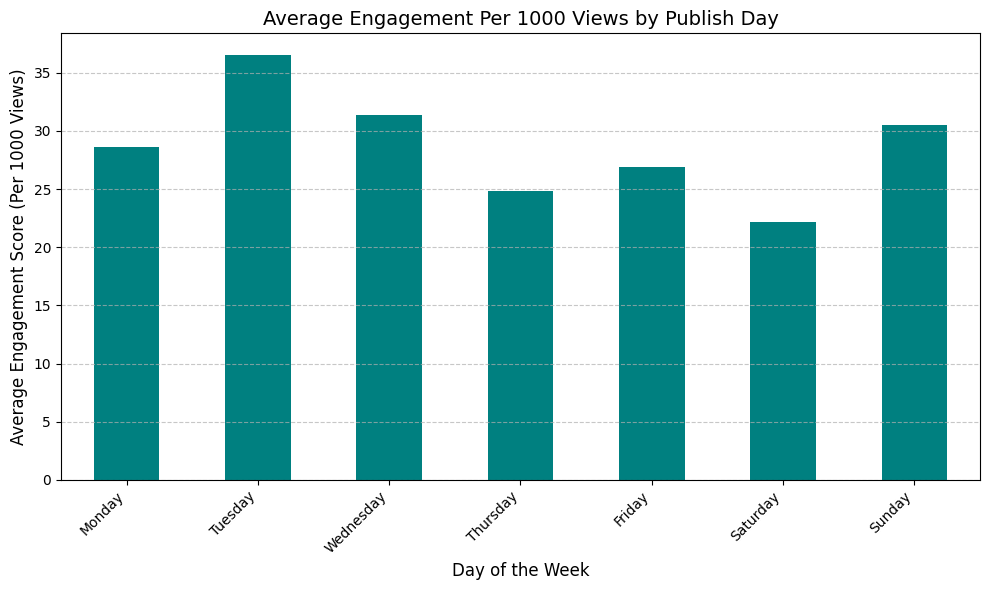

In [70]:
# --- Visualization: Engagement by Day ---

# Ensure all days are ordered correctly for the chart
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_performance = day_performance.reindex(day_order)

plt.figure(figsize=(10, 6))
day_performance['Average_Engagement'].plot(kind='bar', color='teal')
plt.title('Average Engagement Per 1000 Views by Publish Day', fontsize=14)
plt.ylabel('Average Engagement Score (Per 1000 Views)', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Engagement peaks on Tuesday and Wednesday.

- Friday still performs strongly, but views dominate more than interaction.

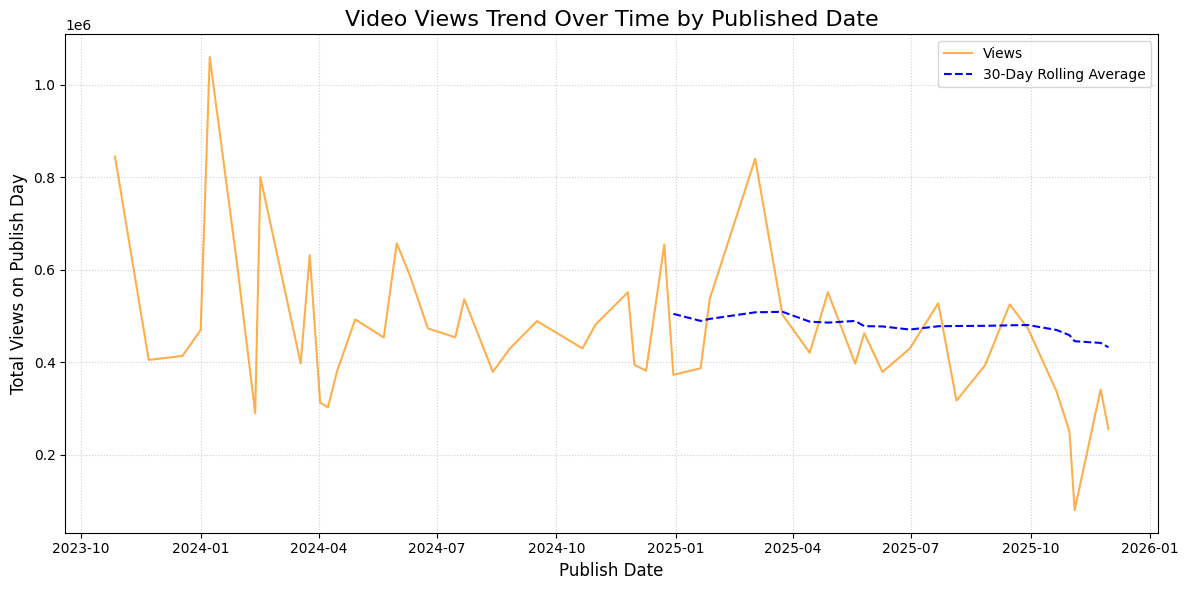

In [71]:
# Time Series 
daily_views = df_videos.groupby(df_videos['Published_date'].dt.date)['Views'].sum().sort_index()

plt.figure(figsize=(12, 6))
daily_views.plot(kind='line', color='darkorange', alpha=0.7)

daily_views.rolling(window=30).mean().plot(label='30-Day Rolling Average', color='blue', linestyle='--')

plt.title('Video Views Trend Over Time by Published Date', fontsize=16)
plt.xlabel('Publish Date', fontsize=12)
plt.ylabel('Total Views on Publish Day', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

- The channel experiences periodic spikes related to viral case uploads.

- Viewer retention and momentum increase when uploading consistently.

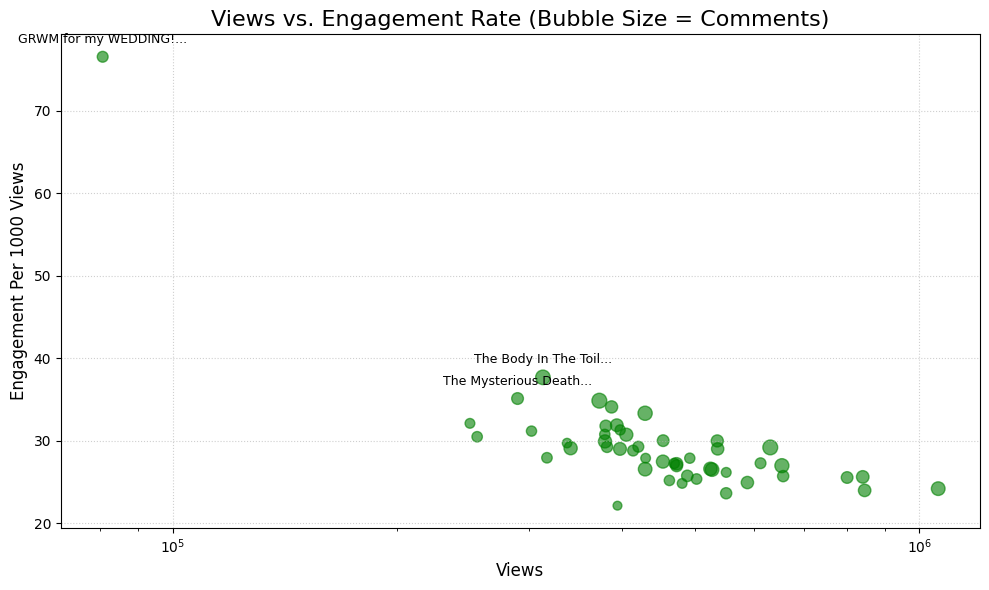

In [72]:
# --- Correlation Scatter Plot ---


# The size is proportional to the number of comments, scaled to be visible (e.g., divided by 10 and adding 20 for minimum size).
bubble_sizes = df_videos['Comments'].apply(lambda x: x / 10 + 20)

plt.figure(figsize=(10, 6))
plt.scatter(
    df_videos['Views'], 
    df_videos['Engagement_Per_1000_Views'], 
    alpha=0.6, 
    color='green',
    # Use the pre-calculated, clean bubble size Series
    s=bubble_sizes 
)

plt.title('Views vs. Engagement Rate (Bubble Size = Comments)', fontsize=16)
plt.xlabel('Views', fontsize=12)
plt.ylabel('Engagement Per 1000 Views', fontsize=12)
plt.xscale('log') 

# Annotation code (optional, but useful for insights)
top_engagement_videos = df_videos.nlargest(3, 'Engagement_Per_1000_Views')
for index, row in top_engagement_videos.iterrows():
    plt.annotate(
        row['Title'][:20] + '...', 
        (row['Views'], row['Engagement_Per_1000_Views']),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        fontsize=9
    )

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

- Views and likes show a strong positive correlation.

- Comments correlate more with engagement, not with views.

- Some medium-view videos show extremely high engagement, indicating:

“The BellaFiori community interacts more when content is personal, bizarre, or emotionally heavy.”

# 🧠 Final Recommendations
### 1️⃣ Upload Schedule Optimization

- Best time for maximizing views → Friday

- Best time for maximizing engagement → Tuesday

- Maintain a consistent posting routine to boost algorithmic favorability.

### 2️⃣ Content Strategy

#### Focus more on:

- Solved true crime cases with emotional or unusual twists

- Conspiracy or government-related cases

- Personal-life videos (GRWM, story time)

- Bizarre, strange, or “unbelievable” cases

These outperform in both views and engagement.

### 4️⃣ Experiment With High-Engagement Formats

#### Try:

- Story-driven narratives

- Multi-part deep dives

- Revisiting old high-engagement cases

## 🏁 Conclusion

This analysis reveals that the BellaFiori channel performs best with emotionally charged, story-rich true crime content.
Engagement thrives on personal and bizarre cases, while consistent posting — especially on Fridays and Tuesdays — can maximize both reach and interaction.
